In [ ]:
from sklearn.naive_bayes import MultinomialNB
from utils.utils import load_cleaned_data, split, metrics

In [ ]:
def tfidf(X_train, X_test):
  pass

In [51]:
# Uses MultinomialNB for the baseline model
def naive_bayes(X_train_tfidf, X_test_tfidf, y_train, alpha):
  model = MultinomialNB(alpha=alpha)
  model.fit(X_train_tfidf, y_train)
  y_pred = model.predict(X_test_tfidf)
  y_pred_proba = model.predict_proba(X_test_tfidf)[:, 1]
  return y_pred, y_pred_proba

Current working directory: C:\Users\Oliver\Documents\school\DAT550-2025---Hyperpartisan-News-Detection--main
Accuracy: 0.76
Precision: 0.77
Recall: 0.50
F1: 0.61


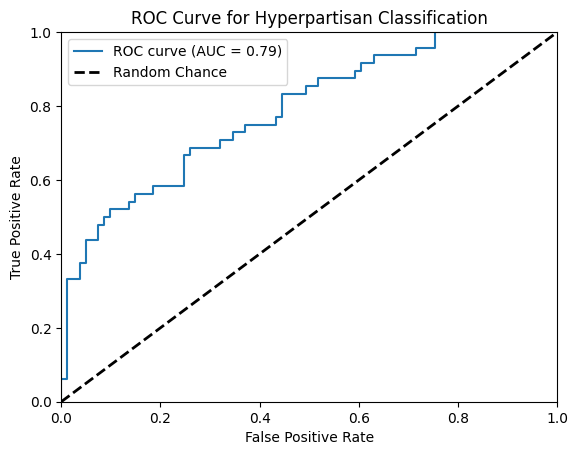

Accuracy: 0.62
Precision: 0.00
Recall: 0.00
F1: 0.00


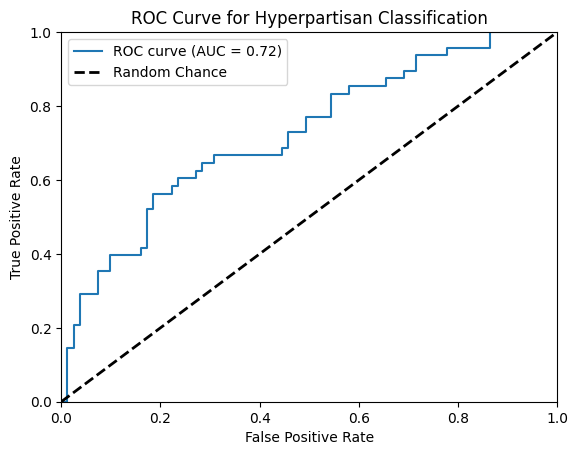

Accuracy: 0.63
Precision: 0.00
Recall: 0.00
F1: 0.00


C:\Users\Oliver\AppData\Roaming\Python\Python38\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


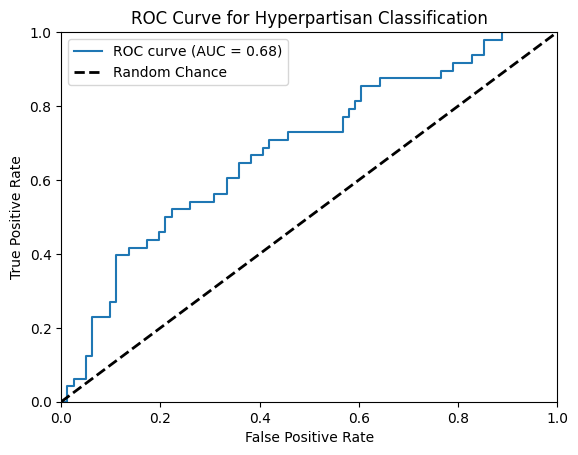

In [ ]:
# Load the data
data = load_cleaned_data("data/preprocessed/byarticle_clean.tsv")

X = data['full_text']
y = data['label']

# Different alpha values for the model
alpha = [0.1, 0.5, 1]

# Split data into train and test parts
X_train, X_test, y_train, y_test = split(X, y)

# Vectorize with tfidf
X_train_tfidf, X_test_tfidf = tfidf(X_train, X_test)

# Run the model different times with different alpha values 
for i in alpha:
  y_pred, y_pred_proba = naive_bayes(X_train_tfidf, X_test_tfidf, y_train, i)
  metrics(y_test, y_pred, y_pred_proba)

